# SIR Model Simulation Using Covid-19 Case Data from Brazil

### Import Statements

In [527]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicHermiteSpline
from scipy.stats import linregress
from scipy.optimize import root_scalar

### Importing Cleaning, and Formatting Case Data

Below, we import the CSSE data from a csv file and reformat the data set to eliminate trivial or flawed data points.

In [528]:
# Read from csv file
reader = np.genfromtxt("time-series-data-brazil.csv", delimiter=",")
days = len(reader[0])

# Create a new np.array with first row as day number
with_date = np.zeros([4, days])
for i in range(days):
    with_date[0,i] = i
    for j in range(1,4):
        with_date[j,i] = reader[j-1,i]

In [529]:
# Find day of first case
for i in range(len(with_date[0])):
    if with_date[1,i] >= 1:
        print(i)
        break
    else:
        continue

# Find first day where recovered numbers are set to 0
for i in range(550,len(with_date[0])):
    if with_date[3,i] == 0:
        print(i)
        break
    else: 
        continue

35
561


In [530]:
# Slice with_date array to create an array of clean data
cleaned = with_date[:,35:561]

Now, we convert the CSSE data to SIR format for use in our model. We then plot the SIR data.  

In [531]:
T = len(cleaned[0]) # total number of days (day 0 to day T - 1)

# Create array to hold SIR data: 1st row is t (date), second row is S(t), third row is I(t), fourth row is R(t)
sir_data = np.zeros([4, T])

pop = 212559409
sir_data[2,0] = 1 # initial number infected
sir_data[1,0] = pop - sir_data[1,0] # initial population

for i in range(1, T):
    sir_data[0,i] = i # day number
    sir_data[3,i] = cleaned[2,i] + cleaned[3,i] # current number recovered
    sir_data[2,i] = cleaned[1,i] - sir_data[3,i] # current number infected
    sir_data[1,i] = pop - sir_data[2,i] - sir_data[3,i]

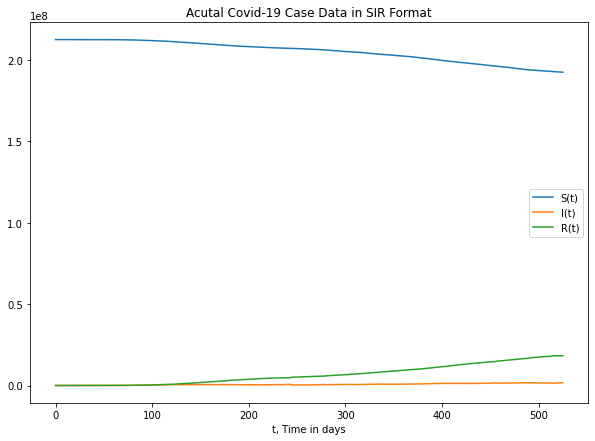

In [532]:
# Plot our curves for S(t), I(t), and R(t)
plt.plot(sir_data[0], sir_data[1], label="S(t)")
plt.plot(sir_data[0], sir_data[2], label="I(t)")
plt.plot(sir_data[0], sir_data[3], label="R(t)")
plt.legend()
plt.xlabel("t, Time in days")
plt.title("Acutal Covid-19 Case Data in SIR Format")
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.savefig("Actual-Data")
plt.show()

## Model 1: Calculation of $\beta$ and $\nu$ Using the Lounis and Bagal Method

Next, we calculate $\beta$ and $\nu$ according to the method described by Lounis and Bagal, find the solution to our system of differential equations, and assess the accuracy of the model with these parameters.

In [533]:
log_plot = np.zeros([2,len(sir_data[0])])
log_plot[0] = sir_data[0]
log_plot[1] = np.log(sir_data[2,])

line_best_fit = linregress(log_plot)

m = line_best_fit.slope

nus = np.zeros([T-1])

for i in range(1,T-1):
    if sir_data[2,i] == 0:
        nus[i-1] = 0
    else:
        nus[i-1] = (sir_data[3, i+1] - sir_data[3,i]) / sir_data[2,i]

nu_lb = np.mean(nus)

b = m + nu_lb
beta_lb = b / pop
print(beta_lb)
print(nu_lb)

2.965251855566585e-10
0.05167572903060111


Now we solve the system of equations and plot the results.

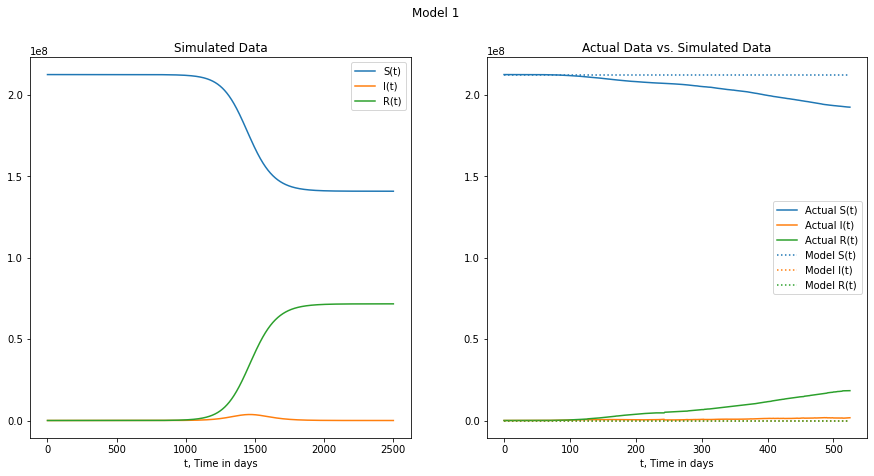

In [534]:
# Define function
def f(t, u):
    S, I, R = u
    dSdt = - beta_lb * S * I
    dIdt = beta_lb * S * I - nu_lb * I
    dRdt = nu_lb * I
    return [dSdt, dIdt, dRdt]

# Set initial conditions
u0 = [sir_data[1,0], sir_data[2,0], sir_data[3,0]]

# Solve system
end = 10000
t_range = [0,end+1]
t = np.arange(t_range[0], t_range[1])

sol = solve_ivp(f, t_span=t_range, y0=u0, t_eval=t, method="LSODA")
sol_y = sol.y

# Plot results
fig, ax = plt.subplots(1,2)

ax[0].plot(sol.t[:2501], sol_y[0,:2501], label="S(t)")
ax[0].plot(sol.t[:2501], sol_y[1,:2501], label="I(t)")
ax[0].plot(sol.t[:2501], sol_y[2,:2501], label="R(t)")
ax[0].legend()
ax[0].set(xlabel="t, Time in days", title="Simulated Data")

ax[1].plot(sir_data[0], sir_data[1], label="Actual S(t)", color="C0")
ax[1].plot(sir_data[0], sir_data[2], label="Actual I(t)", color="C1")
ax[1].plot(sir_data[0], sir_data[3], label="Actual R(t)", color="C2")

ax[1].plot(sol.t[:525], sol_y[0,:525], label="Model S(t)", color="C0", linestyle="dotted")
ax[1].plot(sol.t[:525], sol_y[1,:525], label="Model I(t)", color="C1", linestyle="dotted")
ax[1].plot(sol.t[:525], sol_y[2,:525], label="Model R(t)", color="C2", linestyle="dotted")
ax[1].legend()
ax[1].set(xlabel="t, Time in days", title="Actual Data vs. Simulated Data")

fig.suptitle("Model 1")
fig.set_size_inches(15,7)
plt.savefig("SIR-curves-LB")
plt.show()

Now, we compare the results to the actual Covid-19 case data. 

Below are our calculations of the average error of $S(t)$, $I(t)$, and $R(t)$ as given by our model. We calculate error both as a percentage of the actual data and as a percentage of the population of Brazil. 

In [535]:
# Calculate the average percentage error
S_errors = np.zeros([T])

for i in range(T):
    S_errors[i] = np.abs(sir_data[1,i] - sol_y[0,i]) / sir_data[1,i]
    
S_error = np.mean(S_errors)
print(S_error)

I_errors = np.zeros([T])

for i in range(T):
    I_errors[i] = np.abs(sir_data[2,i] - sol_y[1,i]) / sir_data[2,i]
    
I_error = np.mean(I_errors)
print(I_error)

R_errors = np.zeros([T])

for i in range(T):
    if sir_data[3,i] == 0:
        R_errors[i] = np.nan
    else:
        R_errors[i] = np.abs(sir_data[3,i] - sol_y[2,i]) / sir_data[3,i]
    
R_error = np.nanmean(R_errors)
print(R_error)

0.037052171092960155
0.9884789266223456
0.9956689761795433


In [536]:
# Error as percentage of total population
S_errors = np.zeros([T])

for i in range(T):
    S_errors[i] = np.abs(sir_data[1,i] - sol_y[0,i]) / pop
    
S_error = np.mean(S_errors)
print(S_error)

I_errors = np.zeros([T])

for i in range(T):
    I_errors[i] = np.abs(sir_data[2,i] - sol_y[1,i]) / pop
    
I_error = np.mean(I_errors)
print(I_error)

R_errors = np.zeros([T])

for i in range(T):
    if sir_data[3,i] == 0:
        R_errors[i] = np.nan
    else:
        R_errors[i] = np.abs(sir_data[3,i] - sol_y[2,i]) / pop
    
R_error = np.nanmean(R_errors)
print(R_error)

0.034816170288111514
0.0033379182949921852
0.03265790557071026


### Calculation of $R_0$ and $R_e$

In [537]:
# Lounis and Bagal
R_0 = pop * beta_lb / nu_lb
print(R_0)

R_e = (pop - 1) * beta_lb / nu_lb
print(R_e)

1.219706414944128
1.2197064092059373


### Calculation of $S(10,000)$, $I(10,000)$, the lower bound for $S(\infty)$, and $S(\infty)$

Here, we calculate $S(10,000)$, $I(10,000)$, the lower bound for $S(\infty)$ given by equation (9), and $S(\infty)$ as given by equation (12). These results are discussed in Sections 2.1.3 and 2.1.5.

In [538]:
print(sol_y[0,10000]) # S(10,000)
print(sol_y[1,10000]) # I(10,000)

140881981.79988697
-1.0271775503195752e-11


In [539]:
# Lower bound for S(infty)
print((pop - 1) * np.exp(-R_0))

62772375.83159599


In [540]:
# Solve for S(infty) using the formula given in section 1.2.5

s_inf = lambda x: np.log(x / pop) - R_0 * (x / pop - 1)

# Find root using the secant method; secant method was chosen because S(10,000) serves as a good initial guess
s_inf_root = root_scalar(s_inf, x0=77000000, x1=77008000, method="secant")

print(s_inf_root.root)
print(np.abs(sol_y[0,10000] - s_inf_root.root) / sol_y[0,10000])

140882163.08988294
1.2868217330009712e-06


### Demonstrating that $N(t)$ is Constant and that $\frac{dN}{dt} = 0$

Below, we plot $N(t)$ and $\frac{dN}{dt}$ to demonstrate that they are both constant, with $\frac{dN}{dt} = 0$. 

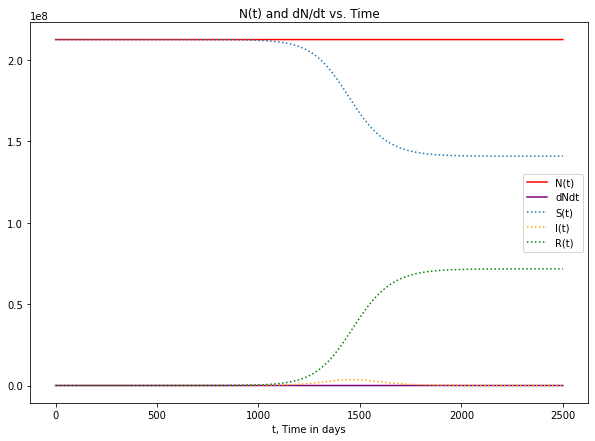

In [541]:
# Plot N(t) = S(t) + I(t) + R(t)
plt.plot(sol.t[:2501], sol_y[0,:2501] + sol_y[1,:2501] + sol_y[2,:2501], label="N(t)", color="red")
plt.plot(sol.t[:2501], f(sol.t[:2501], [sol_y[0,:2501], sol_y[1,:2501], sol_y[2,:2501]])[0] \
         + f(sol.t[:2501], [sol_y[0,:2501], sol_y[1,:2501], sol_y[2,:2501]])[1] \
         + f(sol.t[:2501], [sol_y[0,:2501], sol_y[1,:2501], sol_y[2,:2501]])[2], \
         label="dNdt", color="purple")
plt.plot(sol.t[:2501], sol_y[0,:2501], label="S(t)", color="C0", linestyle="dotted")
plt.plot(sol.t[:2501], sol_y[1,:2501], label="I(t)", color="orange", linestyle="dotted")
plt.plot(sol.t[:2501], sol_y[2,:2501], label="R(t)", color="green", linestyle="dotted")
plt.legend()
plt.xlabel("t, Time in days")
plt.title("N(t) and dN/dt vs. Time")
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.savefig("Nt-dNdt")
plt.show()

### Calcualtion of $I_{max}$

In this section, we calculate $I_{max}$ in three different ways: using equation (11), which defines the theoretical value of $I_{max}$; by interpolating $I(t)$ and then by finding the root of $\frac{dI}{dt}$, which we estimate using the center difference method; and by interpolating $S(t)$, $I(t)$, and $R(t)$ and then finding the root of $\frac{dI}{dt}$, which we find using equation (2). We then calcuate the error of each of the latter two methods with respect to the theoretical value of $I_{max}$. 

In [542]:
# Using formula
I_max = sol_y[0,0] + sol_y[1,0] - (nu_lb / beta_lb) * ( np.log(sol_y[0,0]) + 1 - np.log(nu_lb / beta_lb) )
print("I_max calculated using formula:", I_max)

I_max calculated using formula: 3676461.0385177135


In [543]:
# Using numerical derivation

# Find machine epsilon value 
eps = np.finfo(float).eps

# Optimal value for center difference method: h = eps^{1/3}
h = np.cbrt(eps)

# Interpolate I(t) as given by the solution to the system of diff. eq. 
p = CubicHermiteSpline(sol.t, sol_y[1], f(sol.t, sol_y)[1])

# Write function to estimate dI/dt using the center difference method
def estdIdt(t):
    return (p(t + h) - p(t - h)) / (2 * h)

# Find root of dI/dt; interval taken from inspection of the graph of I(t)
root = root_scalar(estdIdt, bracket=[1200,1600], method="bisect")

# Evaluate I(t) at this point
print("I_max calculated using interpolation and numerical differentiation:", p(root.root))

# Error calculation
print("Absolute error:", np.abs(I_max - p(root.root)))
print("Error as fraction of theoretical value:", np.abs(I_max - p(root.root))/I_max)

I_max calculated using interpolation and numerical differentiation: 3680396.38173325
Absolute error: 3935.343215536326
Error as fraction of theoretical value: 0.001070416135056606


In [544]:
# Using three Cubic Hermite Spline Interpolation polynomials and original dI/dt formula

# Interpolate I(t) as given by the solution to the system of diff. eq. 
pS = CubicHermiteSpline(sol.t, sol_y[0], f(sol.t, sol_y)[0])
pR = CubicHermiteSpline(sol.t, sol_y[2], f(sol.t, sol_y)[2])

# Write function to estimate dI/dt using the center difference method
def render_dIdt(t):
    return f(t, [pS(t),p(t),pR(t)])[1]

# Find root of dI/dt; interval taken from inspection of the graph of I(t)
root = root_scalar(render_dIdt, bracket=[1200,1600], method="bisect")

# Evaluate I(t) at this point
print("I_max calculated using interpolation and given formula for dI/dt:", p(root.root))

# Error calculation
print("Absolute error:", np.abs(I_max - p(root.root)))
print("Error as fraction of theoretical value:", np.abs(I_max - p(root.root))/I_max)

I_max calculated using interpolation and given formula for dI/dt: 3680392.871348529
Absolute error: 3931.832830815576
Error as fraction of theoretical value: 0.0010694613079323763


Above, Cubic Hermite Spline interpolation is used, because it allowed us to force the interpolation polynomial to have the same values for $\frac{dS}{dt}$, $\frac{dI}{dt}$, and $\frac{dR}{dt}$ as those given by equations (1), (2), and (3).

## Model 2: Calcuation of $\beta$ and $\nu$ by Estimating $\frac{dS}{dt}$ and $\frac{dR}{dt}$

To see if we could find parameters that would better reflect the given case data, we estimated $\beta$ and $\nu$ by taking the average value of each of these parameters, calculated through estimates of $\frac{dS}{dt}$ and $\frac{dR}{dt}$ at each point. 

In [558]:
betas = np.zeros([T-2])

for i in range(1,T-1):
    dSdt = (sir_data[1, i+1] - sir_data[1, i-1]) / 2
    minusSI = -1 * sir_data[1,i] * sir_data[2,i]
    if minusSI == 0:
        betas[i-1] = 0
    else:
        betas[i-1] = dSdt / minusSI

beta = np.mean(betas)

nus = np.zeros([T-1])

for i in range(1,T-1):
    dRdt = (sir_data[3, i+1] - sir_data[3, i-1]) / 2
    if sir_data[2,i] == 0:
        nus[i-1] = 0
    else:
        nus[i-1] = dRdt / sir_data[2,i]

nu = np.mean(nus)

print(beta)
print(nu)

3.9644565113428896e-10
0.052767599252613144


Now we solve the system of equations and plot the results.

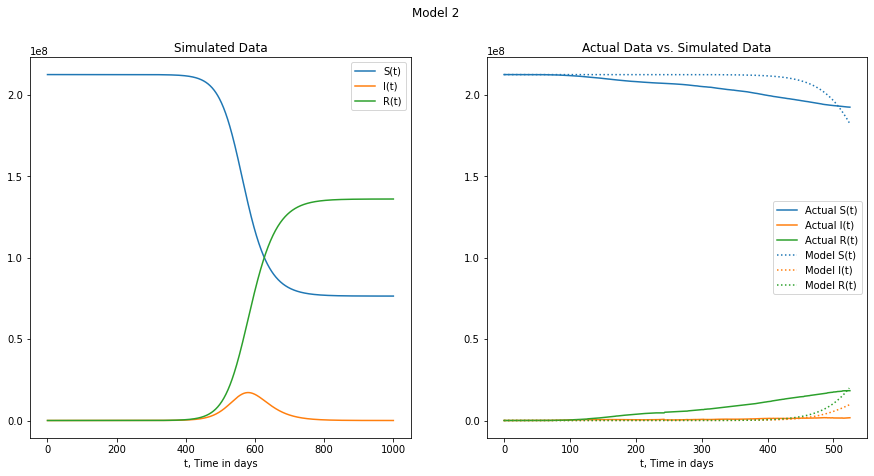

In [546]:
# Define function
def f(t, u):
    S, I, R = u
    dSdt = - beta * S * I
    dIdt = beta * S * I - nu * I
    dRdt = nu * I
    return [dSdt, dIdt, dRdt]

# Set initial conditions
u0 = [sir_data[1,0], sir_data[2,0], sir_data[3,0]]

# Solve system
end = 10000
t_range = [0,end+1]
t = np.arange(t_range[0], t_range[1])

sol = solve_ivp(f, t_span=t_range, y0=u0, t_eval=t, method="LSODA")
sol_y = sol.y

# Plot results
fig, ax = plt.subplots(1,2)

ax[0].plot(sol.t[:1001], sol_y[0,:1001], label="S(t)")
ax[0].plot(sol.t[:1001], sol_y[1,:1001], label="I(t)")
ax[0].plot(sol.t[:1001], sol_y[2,:1001], label="R(t)")
ax[0].legend()
ax[0].set(xlabel="t, Time in days", title="Simulated Data")

ax[1].plot(sir_data[0], sir_data[1], label="Actual S(t)", color="C0")
ax[1].plot(sir_data[0], sir_data[2], label="Actual I(t)", color="C1")
ax[1].plot(sir_data[0], sir_data[3], label="Actual R(t)", color="C2")

ax[1].plot(sol.t[:525], sol_y[0,:525], label="Model S(t)", color="C0", linestyle="dotted")
ax[1].plot(sol.t[:525], sol_y[1,:525], label="Model I(t)", color="C1", linestyle="dotted")
ax[1].plot(sol.t[:525], sol_y[2,:525], label="Model R(t)", color="C2", linestyle="dotted")
ax[1].legend()
ax[1].set(xlabel="t, Time in days", title="Actual Data vs. Simulated Data")


fig.suptitle("Model 2")
fig.set_size_inches(15,7)
plt.savefig("SIR-curves")
plt.show()

Below are our calculations of the average error of $S(t)$, $I(t)$, and $R(t)$ as given by our model. We calculate error both as a percentage of the actual data and as a percentage of the population of Brazil. 

In [547]:
# Calculate the average percentage error
S_errors = np.zeros([T])

for i in range(T):
    S_errors[i] = np.abs(sir_data[1,i] - sol_y[0,i]) / sir_data[1,i]
    
S_error = np.mean(S_errors)
print(S_error)

I_errors = np.zeros([T])

for i in range(T):
    I_errors[i] = np.abs(sir_data[2,i] - sol_y[1,i]) / sir_data[2,i]
    
I_error = np.mean(I_errors)
print(I_error)

R_errors = np.zeros([T])

for i in range(T):
    if sir_data[3,i] == 0:
        R_errors[i] = np.nan
    else:
        R_errors[i] = np.abs(sir_data[3,i] - sol_y[2,i]) / sir_data[3,i]
    
R_error = np.nanmean(R_errors)
print(R_error)

0.02782254077918001
1.052120524660756
0.9093973486586615


In [548]:
# Error as percentage of total population
S_errors = np.zeros([T])

for i in range(T):
    S_errors[i] = np.abs(sir_data[1,i] - sol_y[0,i]) / pop
    
S_error = np.mean(S_errors)
print(S_error)

I_errors = np.zeros([T])

for i in range(T):
    I_errors[i] = np.abs(sir_data[2,i] - sol_y[1,i]) / pop
    
I_error = np.mean(I_errors)
print(I_error)

R_errors = np.zeros([T])

for i in range(T):
    if sir_data[3,i] == 0:
        R_errors[i] = np.nan
    else:
        R_errors[i] = np.abs(sir_data[3,i] - sol_y[2,i]) / pop
    
R_error = np.nanmean(R_errors)
print(R_error)

0.02637320773746283
0.003936572332011358
0.025947347691286007


Our error as a percentage of total population is lower, but still very high; for the rest of the notebook, however, we will use these values for $\beta$ and $\nu$. 

### Calculation of $R_0$ and $R_e$

In [549]:
R_0 = pop * beta / nu
print(R_0)

R_e = (pop - 1) * beta / nu
print(R_e)

1.5969696271818077
1.5969696196687568


### Calculation of $S(10,000)$, $I(10,000)$, the lower bound for $S(\infty)$, and $S(\infty)$

Here, we calculate $S(10,000)$, $I(10,000)$, the lower bound for $S(\infty)$ given by equation (9), and $S(\infty)$ as given by equation (12). These results are discussed in Sections 2.1.3 and 2.1.5.

In [550]:
print(sol_y[0,10000]) # S(10,000)
print(sol_y[1,10000]) # I(10,000)

76453052.81664003
-2.550629242134285e-14


In [557]:
# Lower bound for S(infty)
print((pop - 1) * np.exp(-R_0))

43045250.05171317


In [552]:
# Solve for S(infty) using the formula given in section 1.2.5

s_inf = lambda x: np.log(x / pop) - R_0 * (x / pop - 1)

# Find root using the secant method; secant method was chosen because S(10,000) serves as a good initial guess
s_inf_root = root_scalar(s_inf, x0=77000000, x1=77008000, method="secant")

print(s_inf_root.root)
print(np.abs(sol_y[0,10000] - s_inf_root.root) / sol_y[0,10000])

76447789.22525157
6.884736703827674e-05


### Calcualtion of $I_{max}$

In this section, we calculate $I_{max}$ in three different ways: using equation (11), which defines the theoretical value of $I_{max}$; by interpolating $I(t)$ and then by finding the root of $\frac{dI}{dt}$, which we estimate using the center difference method; and by interpolating $S(t)$, $I(t)$, and $R(t)$ and then finding the root of $\frac{dI}{dt}$, which we find using equation (2). We then calcuate the error of each of the latter two methods with respect to the theoretical value of $I_{max}$. 

In [553]:
# Using formula
I_max = sol_y[0,0] + sol_y[1,0] - (nu / beta) * ( np.log(sol_y[0,0]) + 1 - np.log(nu / beta) )
print("I_max calculated using formula:", I_max)

I_max calculated using formula: 17151725.52458197


In [554]:
# Using numerical derivation

# Find machine epsilon value 
eps = np.finfo(float).eps

# Optimal value for center difference method: h = eps^{1/3}
h = np.cbrt(eps)

# Interpolate I(t) as given by the solution to the system of diff. eq. 
p = CubicHermiteSpline(sol.t, sol_y[1], f(sol.t, sol_y)[1])

# Write function to estimate dI/dt using the center difference method
def estdIdt(t):
    return (p(t + h) - p(t - h)) / (2 * h)

# Find root of dI/dt; interval taken from inspection of the graph of I(t)
root = root_scalar(estdIdt, bracket=[500,600], method="bisect")

# Evaluate I(t) at this point
print("I_max calculated using interpolation and numerical differentiation:", p(root.root))

# Error calculation
print("Absolute error:", np.abs(I_max - p(root.root)))
print("Error as fraction of theoretical value:", np.abs(I_max - p(root.root))/I_max)

I_max calculated using interpolation and numerical differentiation: 17169329.322945636
Absolute error: 17603.79836366698
Error as fraction of theoretical value: 0.0010263572804052338


In [555]:
# Using three Cubic Hermite Spline Interpolation polynomials and original dI/dt formula

# Interpolate I(t) as given by the solution to the system of diff. eq. 
pS = CubicHermiteSpline(sol.t, sol_y[0], f(sol.t, sol_y)[0])
pR = CubicHermiteSpline(sol.t, sol_y[2], f(sol.t, sol_y)[2])

# Write function to estimate dI/dt using the center difference method
def render_dIdt(t):
    return f(t, [pS(t),p(t),pR(t)])[1]

# Find root of dI/dt; interval taken from inspection of the graph of I(t)
root = root_scalar(render_dIdt, bracket=[500,600], method="bisect")

# Evaluate I(t) at this point
print("I_max calculated using interpolation and given formula for dI/dt:", p(root.root))

# Error calculation
print("Absolute error:", np.abs(I_max - p(root.root)))
print("Error as fraction of theoretical value:", np.abs(I_max - p(root.root))/I_max)

I_max calculated using interpolation and given formula for dI/dt: 17169329.322652552
Absolute error: 17603.798070583493
Error as fraction of theoretical value: 0.0010263572633175367


Above, Cubic Hermite Spline interpolation is used, because it allowed us to force the interpolation polynomial to have the same values for $\frac{dS}{dt}$, $\frac{dI}{dt}$, and $\frac{dR}{dt}$ as those given by equations (1), (2), and (3).

## Calculation of Starting and End Dates of Model

Below, we calculate the starting and end dates of CSSE data set and the subset of this data that we used for our model.

In [556]:
data_string = "0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,4,4,13,13,20,25,31,38,52,151,151,162,200,321,372,621,793,1021,1546,1924,2247,2554,2985,3417,3904,4256,4579,5717,6836,8044,9056,10360,11130,12161,14034,16170,18092,19638,20727,22192,23430,25262,28320,30425,33682,36658,38654,40743,43079,45757,50036,54043,59324,63100,67446,73235,79685,87187,92202,97100,101826,108620,115455,126611,135773,146894,156061,162699,169594,178214,190137,203165,220291,233511,241080,255368,271885,291579,310087,330890,347398,363211,374898,391222,411821,438238,465166,498440,514849,526447,555383,584016,614941,645771,672846,691758,707412,739503,772416,802828,828810,850514,867624,888271,923189,955377,978142,1032913,1067579,1083341,1106470,1145906,1188631,1228114,1274974,1313667,1344143,1368195,1402041,1448753,1496858,1539081,1577004,1603055,1623284,1668589,1713160,1755779,1800827,1839850,1864681,1884967,1926824,1966748,2012151,2046328,2074860,2098389,2118646,2159654,2227514,2287475,2343366,2394513,2419091,2442375,2483191,2552265,2610102,2662485,2707877,2733677,2750318,2801921,2859073,2912212,2962442,3012412,3035422,3057470,3109630,3164785,3224876,3275520,3317096,3340197,3359570,3407354,3456652,3501975,3532330,3582362,3605783,3622861,3669995,3717156,3761391,3804803,3846153,3862311,3908272,3950931,3997865,4041638,4091801,4123000,4137521,4147794,4162073,4197889,4238446,4282164,4315687,4330455,4345610,4382263,4419083,4455386,4495183,4528240,4544629,4558040,4591364,4591364,4657702,4689613,4717991,4732309,4745464,4777522,4810935,4847092,4847092,4906833,4915289,4927235,4969141,5000694,5028444,5055888,5082637,5094979,5103408,5113628,5140863,5169386,5200300,5224362,5224362,5250727,5273954,5298772,5323630,5353656,5380635,5394128,5409854,5439641,5468270,5494376,5516658,5535605,5545705,5554206,5566049,5590025,5590025,5631181,5653561,5664115,5675032,5699005,5747660,5781582,5810652,5848959,5863093,5876464,5911758,5945849,5981767,6020164,6052786,6071401,6087608,6118708,6166606,6204220,6238350,6290272,6314740,6335878,6386787,6436650,6487084,6533968,6577177,6603540,6623911,6674999,6728452,6781799,6836227,6880127,6901952,6927145,6970034,7040608,7110434,7162978,7213155,7238600,7263619,7318821,7365517,7423945,7448560,7465806,7484285,7504833,7563551,7619200,7675973,7700578,7716405,7733746,7753752,7810400,7873830,7961673,8013708,8075998,8105790,8131612,8195637,8256536,8324294,8393492,8455059,8488099,8511770,8573864,8638249,8697368,8753920,8816254,8844577,8871393,8933356,8996876,9058687,9118513,9176975,9204731,9229322,9283418,9339420,9396293,9447165,9447165,9524640,9524640,9599565,9659167,9713909,9765455,9809754,9834513,9866710,9921981,9978747,10030626,10084208,10139148,10168174,10195160,10257875,10324463,10390461,10455630,10517232,10551259,10587001,10646926,10718630,10793732,10869227,10938836,11019344,11051665,11122429,11202305,11277717,11363380,11439558,11483370,11519609,11603535,11693838,11780820,11871390,11950459,11998233,12047526,12130019,12220011,12320169,12404414,12490362,12534688,12573615,12658109,12748747,12839844,12910082,12953597,12984956,13013601,13100580,13193205,13279857,13373174,13445006,13482023,13517808,13599994,13673507,13746681,13832455,13900091,13943071,13973695,14043076,14122795,14167973,14237078,14308215,14340787,14369423,14441563,14521289,14590678,14659011,14725975,14754910,14779529,14856888,14930183,15003563,15082449,15145879,15184790,15209990,15282705,15359397,15433989,15519525,15586534,15627243,15657391,15732836,15812055,15894094,15970949,16047439,16083258,16120756,16194209,16274695,16342162,16391930,16471600,16515120,16545554,16624480,16720081,16803472,16841408,16907425,16947062,16984218,17037129,17122877,17210969,17296118,17374818,17412766,17452612,17533221,17628588,17702630,17801462,17883750,17927928,17966831,18054653,18169881,18243483,18322760,18386894,18420598,18448402,18513305,18557141,18622304,18687469,18742025,18769808,18792511,18855015,18909037,18962762,19020499,19069003,19089940,19106971,19151993,19209729,19262518,19308109,19342448,19376574,19391845,19419437,19473954,19523711,19632443,19670534,19688663,19707662,19749073,19797086,19839369,19880273,19917855,19938358,19953501,19985817,20026533,20066587,20108746,20151779,20165672,20177757,20212642,20245085,20285067,20319000,20350142,20364099,20378570,20416183,20457897,20494212,20528099,20556487,20570891,20583994,20614866,20645537,20676561,20703906,20728605,20741815,20752281,20776870,20804215,20830495,20856060,20877864,20890779,20899933,20914237,20928008,20958899,20974850,20989164,20999779,21006424,21019830,21034610,21069017,21080219,21230325,21239783,21247667,21247094,21283567,21308178,21327616,21343304,21351972,21366395,21381790,21399546,21427073,21445651,21459117,21468121,21478546,21499074,21516967,21532558,21550730,21567181,21575820,21582738,21590097,21597949,21612237,21627476,21638726,21644464,21651910,21664879,21680488,21697341,21711843,21723559,21729763,21735560,21748984,21766168,21781436,21793401,21804094,21810855,21814693,21821124,21835785,21849137,21862458,21874324,21880439,21886077,21897025,21909298,21924598,21939196,21953838,21957967,21960766,21965684,21977661,21989962,22003317,22012150,22017276,22019870,22030182,22043112,22055238,22067630,22076863,22080906,22084749,22094459,22105872,22118782"
dss = data_string.split(",")
print("Number of days in CSSE data set:", len(dss))

from datetime import date
from datetime import timedelta

d1 = date(2020,1,22)
print("First day of CSSE data:", d1)
print("Final day of CSSE data:", d1 + timedelta(680))

print("\nNumber of days in model:", len(sir_data[0]))
print("First day of our model:", d1 + timedelta(35))
print("Final day of our model:", d1 + timedelta(561))

Number of days in CSSE data set: 681
First day of CSSE data: 2020-01-22
Final day of CSSE data: 2021-12-02

Number of days in model: 526
First day of our model: 2020-02-26
Final day of our model: 2021-08-05
